<a id='topo'></a>
# Penetração de Planos de Saúde e Possibilidades para Empresas do Setor

- Queremos analisar a taxa de penetração de planos de saúde na população e investigar que fatores a influenciam e como ela evolui.
- Essa análise foca também em entender como a participação das empresas no mercado de cada região evoluiu nos últimos anos.
- Por último, exploramos um cenário simples construído a partir da combinação dos dois fatores anteriores.

## Índice

- [Principais Conclusões](#0)
- [1. Estatísticas Básicas de Cobertura](#1)
    - [1.1. Existe disparidade regional de penetração?](#1.1)
    - [1.2. Como a cobertura muda de acordo com a faixa etária?](#1.2)
    - [1.3. Distribuição da cobertura por faixa etária e região](#1.3)
- [2. Relação da Penetração de Serviços de Saúde com Emprego e Renda](#2)
    - [2.1. Correlação com a renda per capita (Município)](#2.1)
    - [2.2. Correlação com a desocupação (UF)](#2.2)
    - [2.3. O que diz o "Caderno de Informação da Saúde Suplementar" de Março de 2020](#2.3)
- [3. Como a cobertura tem variado ao longo do tempo?](#3)
- [4. Participação das Operadoras: Share por Região (2012-2020)](#4)
- [5. Projeção do número de Beneficiários de Cada Empresa](#5)

<a id='0'></a>
## Principais Conclusões

1. Unimeds 
    1. Tem perdido Market Share em todas as regiões (2012 a 2020)
    2. Apesar disso, número de beneficiários total segue crescendo, ainda que mais lentamente que o de outras companhias.
    3. Projetados >7M novos clientes nos próximos 10 anos, a uma taxa de 3.5% de crescimento ao ano. Esse valor aponta para solidez, mesmo no atual cenário de perda de mercado, mas não para cenário de crescimento acelerado.
2. HAPVIDA
    1. Aparece como a empresa de maior crescimento absoluto de beneficiários, com uma aceleração significativa, despontando como um grande player nacional.
    2. Tem apresentado crescimento acelerado e tende a ser a OPS que mais vai se beneficiar do aumento da penetração de planos de saúde nas regiões Norte, Nordeste e Centro - Oeste.
    3. Como essas regiões tem crescido de forma mais rápida e continuam sendo as de menor cobertura, pode-se supor que continuarão crescendo de forma mais acelerada, em um movimento de "catch-up".
    4. Aparenta estar em momento para o qual já adquiriu experiencia ao analisar as 3 regiões citadas, o que sugere que a empresa deve ter maior facilidade ao replicar o modelo de expansão já usado no Nordeste.
3. GNDI
    1. Tem crescimento sustentado na região Sudeste, apesar de não estar ganhando participação de forma acelerada.
    2. Na região Sul, aumento de participação e consolidação como segundo player de maior relevancia tem o potencial de trazer grande expansão ao tomar parte do market share das unimeds, como visto nas regiões N, NE, CO
    3. Deve ser a empresa com maior ganho percentual de beneficiários
4. Prevent
    1. Crescimento acelerado (o maior dentre os projetados)
    2. Apesar disso, seu mercado é relativamente mais sujeito a saturação, já que as projeções feitas não consideram a faixa etária da população
    3. No geral, aparece como um player de crescimento relevante, que deve consolidar parte dos grandes mercados de faixas etárias mais altas
5. Sulamerica
    1. A projeção aponta para crescimento significativo dos serviços de gestão de planos de terceiros (ASO)
    2. Serviços próprios apresentam crescimento sustentado, acima das Unimeds.

[↑](#topo)

In [1]:
import os
from typing import List

import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
plt.style.use('fivethirtyeight')

In [3]:
def cagr(data: pd.DataFrame, date_col: str, groups: List[str], metric: str, n_periods: float):
    """Calculate compound annual growth ratio for a given metric."""
    df = data.copy()
    growth = df.groupby(groups + [date_col]).sum()
    growth = growth.reset_index()
    compound = growth.groupby(groups)[metric].last() / growth.groupby(groups)[metric].first()
    compound = 100 * (compound ** (1 / n_periods) - 1)
    compound = compound.reset_index()
    return compound


def add_value_labels(ax, spacing=5):
    """Add labels to the end of each bar in a bar chart.

    Arguments:
        ax (matplotlib.axes.Axes): The matplotlib object containing the axes
            of the plot to annotate.
        spacing (int): The distance between the labels and the bars.
    """

    # For each bar: Place a label
    for rect in ax.patches:
        # Get X and Y placement of label from rect.
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2

        # Number of points between bar and label. Change to your liking.
        space = spacing
        # Vertical alignment for positive values
        va = 'bottom'

        # If value of bar is negative: Place label below bar
        if y_value < 0:
            # Invert space to place label below
            space *= -1
            # Vertically align label at top
            va = 'top'

        # Use Y value as label and format number with one decimal place
        label = "{:.2f}".format(y_value)

        # Create annotation
        ax.annotate(
            label,                      # Use `label` as label
            (x_value, y_value),         # Place label at end of the bar
            xytext=(0, space),          # Vertically shift label by `space`
            textcoords="offset points", # Interpret `xytext` as offset in points
            ha='center',                # Horizontally center label
            va=va)                      # Vertically align label differently for
                                        # positive and negative values.

<a id='1'></a>
## 1. Estatísticas Básicas de Cobertura

Um primeiro passo para entender a penetração de planos de saúde é explorar sua relação com elementos demográficos.
Alguns fatores figuram especialmente nesse momento, como a região geográfica, a idade e o genero.

Aqui, algumas hipóteses surgem:
1. A penetração de planos de saúde tem relação com a renda e deve ser maior nas regiões com maior renda per capita do país.
2. A contratação de planos de saúde, como uma aquisição de produto de seguros, está relacionada à percepção de risco do cliente. Assim, deve haver maior penetração em faixas de idade mais avançadas.
3. A contratação de planos de saúde deve estar relacionada com a percepção da qualidade do serviço público de saúde. Localidades com maior satisfação com o SUS devem ter menor cobertura.

Exploramos abaixo as hipóteses 1 e 2.

[↑](#topo)

In [4]:
cobertura = pd.read_csv('../data/01_raw/taxa_cobertura.csv', 
                        encoding='latin1', sep=';')
cobertura = cobertura.rename(columns=str.lower)

<a id='1.1'></a>
### 1.1. Existe disparidade regional de penetração?

Temos diferenças significativas de contratação de assistencia médica em todo o país. Estados das regiões Norte e Nordeste mostram penetração muito menor que estados das regiões Sul e Sudeste.
Podemos notar também diferenças significativas entre estados de uma mesma região (eg. 15% de diferença entre SP e MG).

- A região Sudeste tem maior cobertura, com São Paulo sendo o estado com maior penetração. 
- As regiões Norte e Nordeste tem uma cobertura pequena e concentrada nas regiões metropolitanas, com menos de 5% da população coberta em outras áreas.
- As regiões Sul e Centro-Oeste parecem estar em um estado "intermediário" de cobertura.

Com essas disparidades, torna-se interessante notar como a cobertura tem avançado nas últimas décadas em cada região, para tentar identificar possíveis efeitos de "catching-up" nas regiões de menor cobertura. Analisamos isso no Ponto 3.

[↑](#topo)

In [5]:
cobertura['fl_regiao_metropolitana'] = cobertura['cd_rm'] != 0 & ~cobertura['cd_rm'].astype(str).str.endswith('90')
cobertura['tx_cobert_assistencia_medica'] = cobertura['tx_cobert_assistencia_medica'].str.replace(',', '.')
cobertura['tx_cobert_assistencia_medica'] = cobertura['tx_cobert_assistencia_medica'].astype(float)
cobertura['tx_cobert_assistencia_medica'] = cobertura['tx_cobert_assistencia_medica'] / 100
cobertura = cobertura[~cobertura['sg_uf'].isin(('EX', 'XX'))]

In [6]:
regioes = {
    'AC': 'N',
    'AL': 'NE',
    'AM': 'N',
    'AP': 'N',
    'BA': 'NE',
    'CE': 'NE',
    'DF': 'CO',
    'ES': 'SE',
    'GO': 'CO',
    'MA': 'NE',
    'MG': 'SE',
    'MS': 'CO',
    'MT': 'CO',
    'PA': 'N',
    'PB': 'NE',
    'PE': 'NE',
    'PI': 'NE',
    'PR': 'S',
    'RJ': 'SE',
    'RN': 'NE',
    'RO': 'N',
    'RR': 'N',
    'RS': 'S',
    'SC': 'S',
    'SE': 'NE',
    'SP': 'SE',
    'TO': 'N',
}
cobertura['regiao'] = cobertura['sg_uf'].map(regioes)

#### Penetração por Estado (UF)

In [7]:
uf = cobertura.groupby(['sg_uf', 'regiao'])[['populacao', 'benef_assistencia_medica']].sum()
uf['perc_cobert_assistencia_medica'] = (uf['benef_assistencia_medica'] / uf['populacao'])
uf['perc_cobert_assistencia_medica'] = 100 * uf['perc_cobert_assistencia_medica']
uf = uf.reset_index()

Text(0.5, 1.0, 'Penetração por UF')

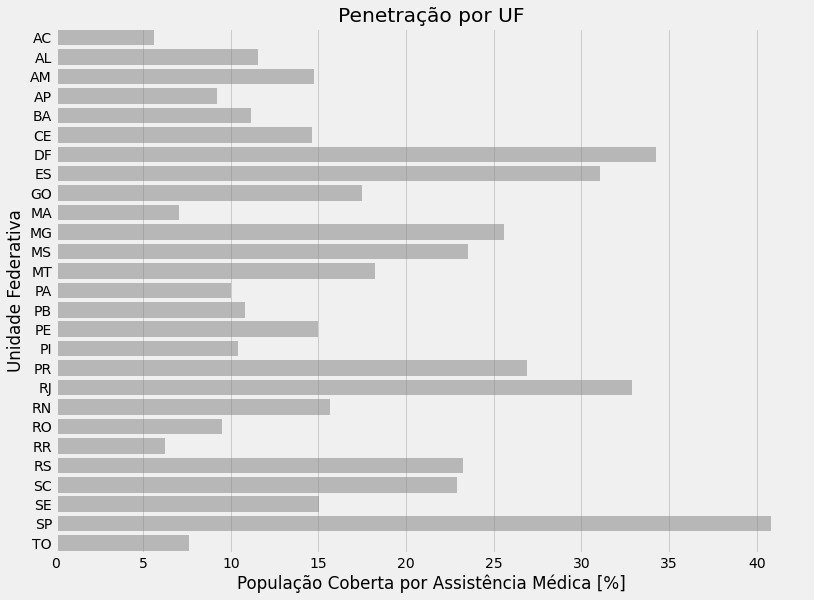

In [8]:
_, ax = plt.subplots(1, figsize=(12, 9))
sns.barplot(data=uf, y='sg_uf', x='perc_cobert_assistencia_medica', 
            ax=ax, color='grey', alpha=0.5)
plt.xlabel('População Coberta por Assistência Médica [%]')
plt.ylabel('Unidade Federativa')
plt.title('Penetração por UF')

#### Penetração por Região

In [9]:
regiao = cobertura.groupby(['regiao'])[['populacao', 'benef_assistencia_medica']].sum()
regiao['perc_cobert_assistencia_medica'] = (regiao['benef_assistencia_medica'] / regiao['populacao'])
regiao['perc_cobert_assistencia_medica'] = 100 * regiao['perc_cobert_assistencia_medica']
regiao = regiao.reset_index()

Text(0.5, 1.0, 'Penetração por Região')

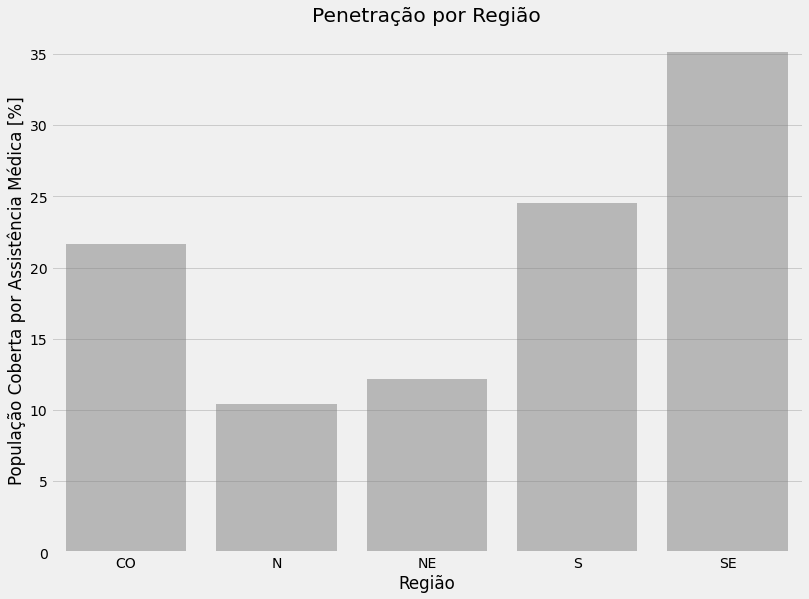

In [10]:
_, ax = plt.subplots(1, figsize=(12, 9))
sns.barplot(data=regiao, x='regiao', y='perc_cobert_assistencia_medica', 
            ax=ax, color='grey', alpha=0.5)
plt.xlabel('Região')
plt.ylabel('População Coberta por Assistência Médica [%]')
plt.title('Penetração por Região')

#### Disparidade entre Regiões Metropolitanas e Demais Áreas

Text(0.5, 1.0, 'Penetração por Região - Regiões Metropolitanas')

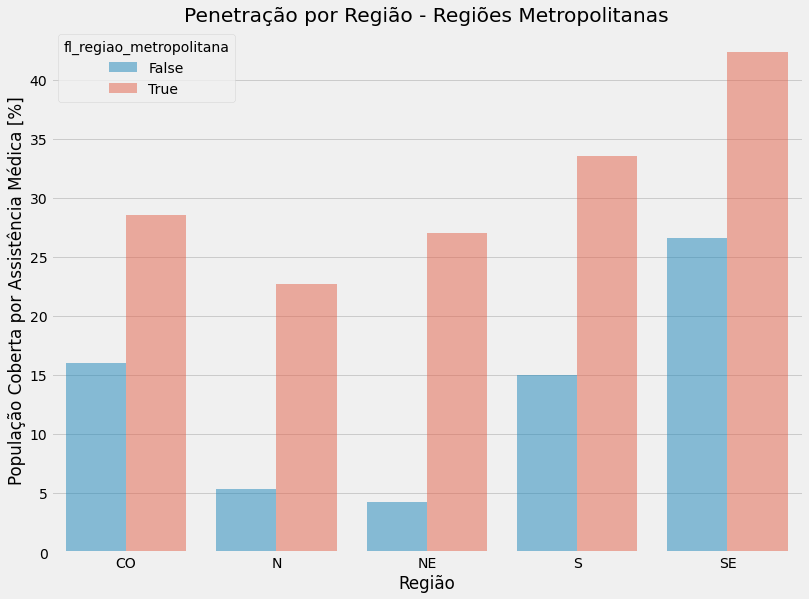

In [11]:
df = cobertura.groupby(['regiao', 'fl_regiao_metropolitana'])[['populacao', 'benef_assistencia_medica']].sum()
df['perc_cobert_assistencia_medica'] = (df['benef_assistencia_medica'] / df['populacao'])
df['perc_cobert_assistencia_medica'] = 100 * df['perc_cobert_assistencia_medica']
df = df.reset_index()

_, ax = plt.subplots(1, figsize=(12, 9))
sns.barplot(data=df, x='regiao', 
            y='perc_cobert_assistencia_medica', 
            hue='fl_regiao_metropolitana',
            ax=ax, alpha=0.5)
plt.xlabel('Região')
plt.ylabel('População Coberta por Assistência Médica [%]')
plt.title('Penetração por Região - Regiões Metropolitanas')

<a id='1.2'></a>
### 1.2 Como a cobertura muda de acordo com a faixa etária?

- Maior cobertura entre pessoas com mais de 80 anos.
- Patamar de cerca de 20% de cobertura para crianças de até 10 anos.
- Mínimo de cobertura em público de 10 a 20 anos.
- Cobertura estável em público de 30 a 79 anos.

Isso indica uma relação com a percepção de risco da idade avançada, mas também sugere que há um "gap" na faixa dos 30 anos.
Esse efeito poderia ser explicado pelo início ou estabilização de uma vida profissional, com renda estável ou emprego que ofereça um plano de saúde como parte da compensação.
Podemos ver no "Caderno de Informação da Saúde Suplementar" que os contratos de planos de saúde empresariais respondem por mais de 60% dos contratos no Brasil. 
Isso sugere uma relação com emprego formal, em especial em cenários de maior competitividade, o que pode ajudar a explicar a maior penetração nos grandes centros urbanos.

[↑](#topo)

In [12]:
faixas_etarias = {
    'Até 1 ano': '01. [0, 1[',
    '1 a 4 anos': '02. [1, 4]',
    '5 a 9 anos': '03. [5, 9]',
    '10 a 14 anos': '04. [10, 14]',
    '15 a 19 anos': '05. [15, 19]',
    '20 a 29 anos': '07. [20, 29]',
    '30 a 39 anos': '08. [30, 39]',
    '40 a 49 anos': '09. [40, 49]',
    '50 a 59 anos': '10. [50, 59]',
    '60 a 69 anos': '11. [60, 69]',
    '70 a 79 anos': '12. [70, 79]',
    '80 anos ou mais': '13. [80, inf[',
}
cobertura['cat_fx_etaria'] = cobertura['faixa_etaria'].map(faixas_etarias)

Text(0.5, 1.0, 'Penetração por Faixa Etária')

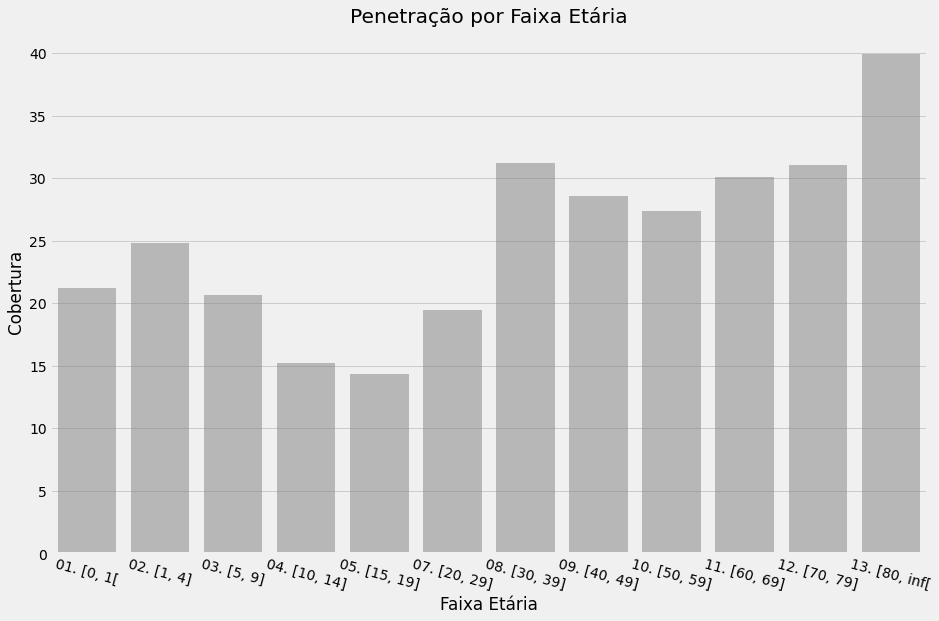

In [13]:
df = cobertura.groupby(['cat_fx_etaria'])[['populacao', 'benef_assistencia_medica']].sum()
df['perc_cobert_assistencia_medica'] = (df['benef_assistencia_medica'] / df['populacao'])
df['perc_cobert_assistencia_medica'] = 100 * df['perc_cobert_assistencia_medica']
df = df.reset_index()

_, ax = plt.subplots(1, figsize=(14, 9))
sns.barplot(data=df, x='cat_fx_etaria', 
            y='perc_cobert_assistencia_medica', 
            color='grey', ax=ax, alpha=0.5)
plt.xlabel('Faixa Etária')
plt.ylabel('Cobertura')
plt.xticks(rotation=-15)

plt.title('Penetração por Faixa Etária')

#### Disparidade nas Regiões Metropolitanas

Text(0.5, 1.0, 'Penetração por Faixa Etária - Regiões Metropolitanas')

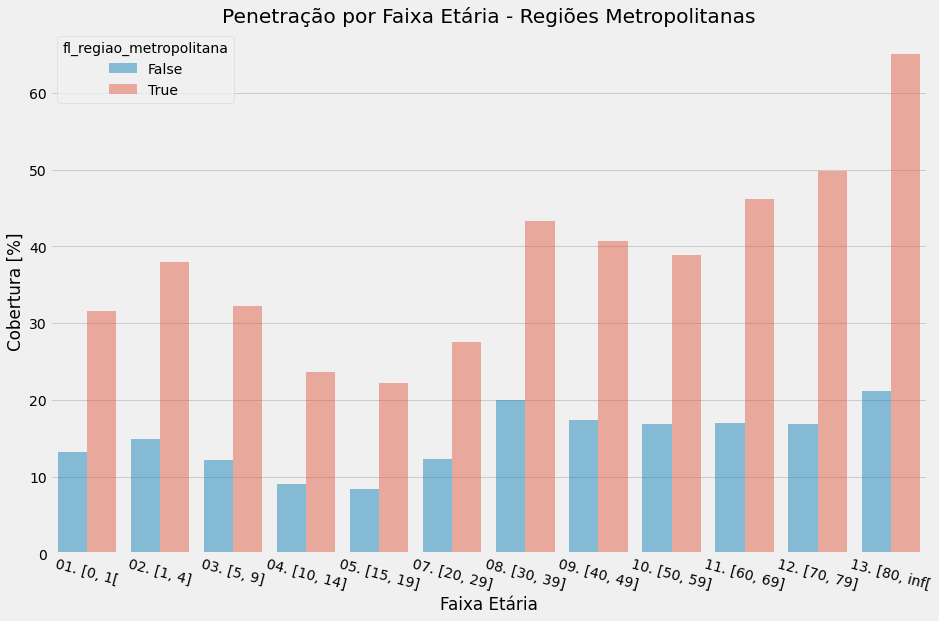

In [14]:
df = cobertura.groupby(['cat_fx_etaria', 'fl_regiao_metropolitana'])[['populacao', 'benef_assistencia_medica']].sum()
df['perc_cobert_assistencia_medica'] = (df['benef_assistencia_medica'] / df['populacao'])
df['perc_cobert_assistencia_medica'] = 100 * df['perc_cobert_assistencia_medica']
df = df.reset_index()

_, ax = plt.subplots(1, figsize=(14, 9))
sns.barplot(data=df, x='cat_fx_etaria', y='perc_cobert_assistencia_medica', hue='fl_regiao_metropolitana',
            ax=ax, alpha=0.5)
plt.xlabel('Faixa Etária')
plt.ylabel('Cobertura [%]')
plt.xticks(rotation=-15)
plt.title('Penetração por Faixa Etária - Regiões Metropolitanas')

<a id='1.3'></a>
### 1.3 Distribuição da cobertura por faixa etária e região

- Regiões Metropolitanas
    - Por fim, se observarmos a distribuição da penetração como uma combinação de região geográfica, proximidade a um centro urbano e faixa etária, podemos ver grande concentração da penetração de planos de saúde.
    - As faixas etárias de 10 a 29 anos seguem com destaque negativo em todos os cenários
    - As discrepancias entre as regioes Centro-Oeste, Nordeste e Sul se tornam menores fora desta faixa etária.

- Demais Regiões
    - Fora das RMs, há penetração muito baixa nas regiões Nordeste e Norte, que tem um território vasto e frequentemente muito pobre em infraestrutura. 
    - As regiões Centro-Oeste e Sul seguem parecidas, com cobertura maior entre idosos da região Sul e entre jovens da Centro-Oeste, comparativamente.
    
[↑](#topo)    

Text(0.5, 0.98, 'Penetração de Assistencia Médica por Segmento [%]')

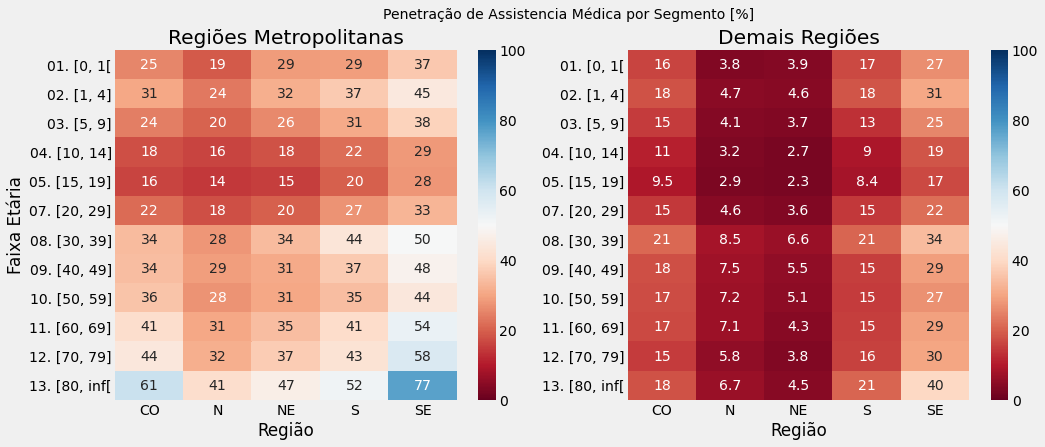

In [15]:
def plot_cobertura_bivar(data: pd.DataFrame, lines: str, columns: str, ax=None):
    if ax is None:
        _, ax = plt.subplots(1, figsize=(12, 9))

    df = (
        data
        .groupby([lines, columns])
        [['populacao', 'benef_assistencia_medica']]
        .sum()
    )
    df['perc_cobert_assistencia_medica'] = (df['benef_assistencia_medica'] / df['populacao'])
    df['perc_cobert_assistencia_medica'] = 100 * df['perc_cobert_assistencia_medica']
    df = df.reset_index()
    table = pd.pivot(df, lines, columns, 'perc_cobert_assistencia_medica')

    sns.heatmap(table, vmin=0, vmax=100, cmap='RdBu', ax=ax, annot=True)

    
fig, axs = plt.subplots(1, 2, figsize=(15, 6))
plot_cobertura_bivar(cobertura.query('fl_regiao_metropolitana'), 'cat_fx_etaria', 'regiao', axs[0])
plot_cobertura_bivar(cobertura.query('not fl_regiao_metropolitana'), 'cat_fx_etaria', 'regiao', axs[1])

axs[0].set_xlabel('Região')
axs[0].set_ylabel('Faixa Etária')
axs[0].set_title('Regiões Metropolitanas')
axs[1].set_xlabel('Região')
axs[1].set_ylabel('')
axs[1].set_title('Demais Regiões')
fig.suptitle("Penetração de Assistencia Médica por Segmento [%]", fontsize=14)

<a id='2'></a>
## 2. Relação da Penetração de Serviços de Saúde com Emprego e Renda

- Temos indicativos de uma relação com renda pelas fortes disparidades regionais. 
- Uma forma de tentar mensurar essa relação é correlacionar o percentual de cobertura em um município com sua renda per capita.
- Aqui, novamente separamos entre RMs e demais regiões para visualizar possíveis diferenças, mas a relação com renda se mantém direta em ambos.
- A imagem abaixo, de estudo do Insper sobre a cadeia de saúde suplementar no Brasil, indica o gasto anual médio das famílias com saúde.

![gastos-saude](../data/images/insper-gasto-saude.png)

[↑](#topo)

In [16]:
cities = pd.read_json(path_or_buf='../data/01_raw/citiesCensusData.json', orient='records', typ='frame', dtype=None, 
                      convert_axes=None, convert_dates=True, keep_default_dates=True, precise_float=False, 
                      date_unit=None, encoding=None, lines=False, chunksize=None, compression='infer')
cities = cities.rename(columns=str.lower)
cities['codigo'] = cities['codigo'].apply(lambda val: val // 10)

In [17]:
df = cobertura.groupby(['cd_municipio', 'fl_regiao_metropolitana'])[['populacao', 'benef_assistencia_medica']].sum()
df['perc_cobert_assistencia_medica'] = (df['benef_assistencia_medica'] / df['populacao'])
df['perc_cobert_assistencia_medica'] = 100 * df['perc_cobert_assistencia_medica']
df = df.reset_index()
municipios = df.copy()

In [18]:
df = municipios.merge(cities, left_on='cd_municipio', right_on='codigo', how='inner')

<a id='2.1'></a>
### 2.1 Correlação - Percentual de Cobertura v Renda per capita (Município)

[↑](#topo)

Text(0.5, 1.0, 'Demais Regiões')

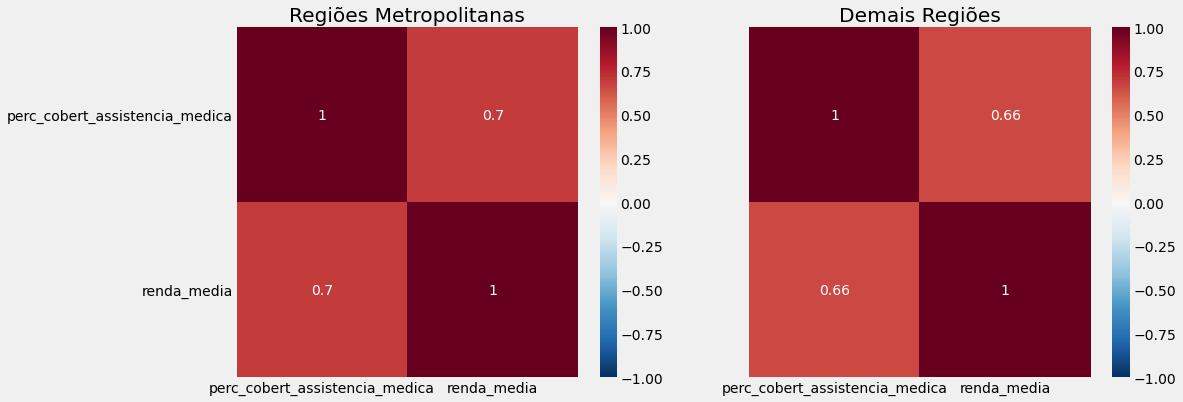

In [19]:
_, axs = plt.subplots(1, 2, figsize=(15, 6))

corr = df.query('fl_regiao_metropolitana')[[
    'perc_cobert_assistencia_medica', 
    'renda_media'
]].corr()
axs[0].set_title('Regiões Metropolitanas')
sns.heatmap(corr, vmin=-1, vmax=1, cmap='RdBu_r', annot=True, ax=axs[0])


corr = df.query('not fl_regiao_metropolitana')[[
    'perc_cobert_assistencia_medica', 
    'renda_media'
]].corr()
sns.heatmap(corr, vmin=-1, vmax=1, cmap='RdBu_r', annot=True, ax=axs[1], yticklabels=[])
axs[1].set_title('Demais Regiões')

<a id='2.2'></a>
### 2.2 Correlação - Percentual de Cobertura v Desocupação (UF)

- Considerando a forte contribuição de planos empresariais na cobertura de assistencia médica, podemos supor que um choque no nível de emprego gerará um movimento proporcional na penetração de planos de saúde.
- Para diferentes UFs, podemos analisar a correlação entre o nível de desocupação medido pela PNADC - IBGE e o percentual de cobertura de assistencia.
- Uma correlação negativa aqui nos indica que o aumento da desocupação está correlacionado com uma redução da penetração de planos de saúde.
- Esse comportamento se mantém para regiões metropolitanas e não-metropolitanas.
- Uma medida mais relevante para esse contexto é a variação do nível de emprego formal, já que a desocupação considera também trabalhadores informais.

[↑](#topo)

In [20]:
desocupacao_uf = pd.read_csv('../data/01_raw/desocupacao_uf_2019.csv')

In [21]:
df = cobertura.groupby(['sg_uf'])[['populacao', 'benef_assistencia_medica']].sum()
df['perc_cobert_assistencia_medica'] = (df['benef_assistencia_medica'] / df['populacao'])
df['perc_cobert_assistencia_medica'] = 100 * df['perc_cobert_assistencia_medica']
df = df.reset_index()
estados = df.copy()

estados = estados.merge(desocupacao_uf, on='sg_uf', how='left')

Text(0.5, 1.0, 'Correlação da Desocupação com Cobertura')

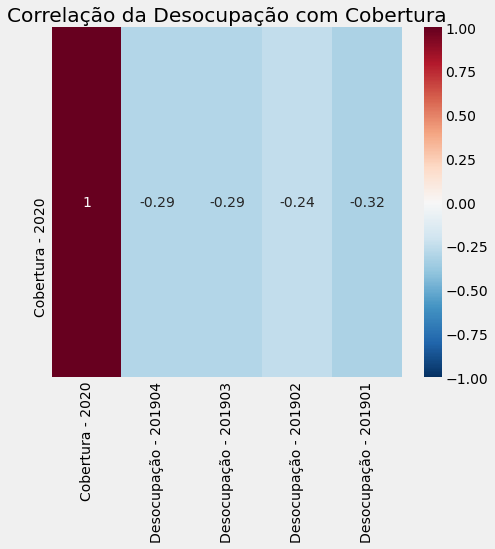

In [22]:
corr = estados[['perc_cobert_assistencia_medica', '201904', '201903', '201902', '201901']].corr()

_, ax = plt.subplots(1, figsize=(7, 6))
g = sns.heatmap([corr.iloc[0]], vmin=-1, vmax=1, cmap='RdBu_r', annot=True, ax=ax)
g.set_xticklabels(['Cobertura - 2020', 'Desocupação - 201904', 'Desocupação - 201903', 'Desocupação - 201902', 'Desocupação - 201901'], rotation=90)
g.set_yticklabels(['Cobertura - 2020'])
plt.title('Correlação da Desocupação com Cobertura')

In [23]:
df = cobertura.groupby(['sg_uf', 'fl_regiao_metropolitana'])[['populacao', 'benef_assistencia_medica']].sum()
df['perc_cobert_assistencia_medica'] = (df['benef_assistencia_medica'] / df['populacao'])
df['perc_cobert_assistencia_medica'] = 100 * df['perc_cobert_assistencia_medica']
df = df.reset_index()
estados = df.copy()

estados = estados.merge(desocupacao_uf, on='sg_uf', how='left')

Text(0.5, 0.98, 'Correlação da Desocupação com Cobertura')

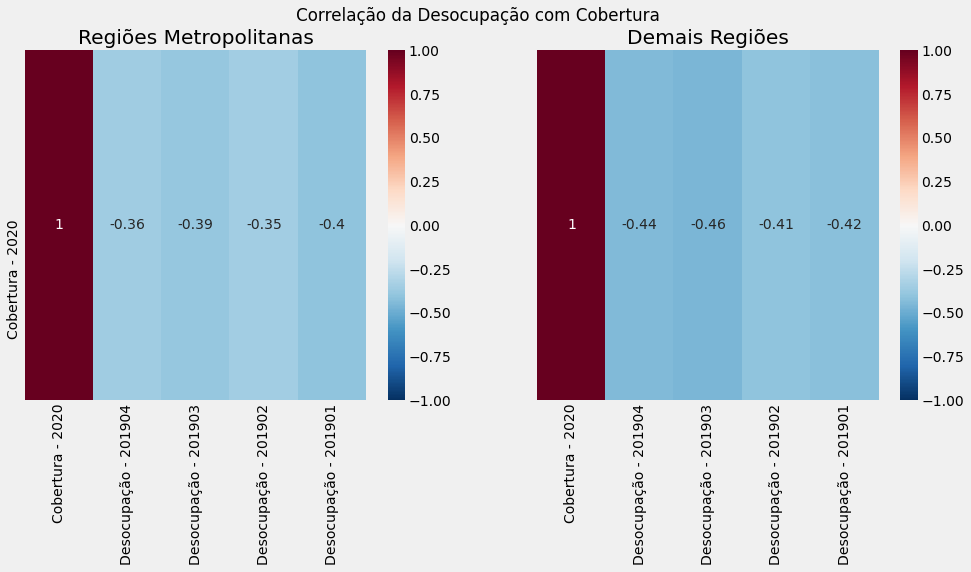

In [24]:
fig, axs = plt.subplots(1, 2, figsize=(15,6))

corr = estados.query('fl_regiao_metropolitana')[[
    'perc_cobert_assistencia_medica', '201904', '201903', '201902', '201901'
]].corr()
g0 = sns.heatmap([corr.iloc[0]], vmin=-1, vmax=1, cmap='RdBu_r', annot=True, ax=axs[0])
g0.set_xticklabels(['Cobertura - 2020', 'Desocupação - 201904', 'Desocupação - 201903', 'Desocupação - 201902', 'Desocupação - 201901'], rotation=90)
g0.set_yticklabels(['Cobertura - 2020'])
axs[0].set_title('Regiões Metropolitanas')

corr = estados.query('not fl_regiao_metropolitana')[[
    'perc_cobert_assistencia_medica', '201904', '201903', '201902', '201901'
]].corr()
g1 = sns.heatmap([corr.iloc[0]], vmin=-1, vmax=1, cmap='RdBu_r', annot=True, ax=axs[1], yticklabels=[])
g1.set_xticklabels(['Cobertura - 2020', 'Desocupação - 201904', 'Desocupação - 201903', 'Desocupação - 201902', 'Desocupação - 201901'], rotation=90)
g1.set_yticklabels(['Cobertura - 2020'])
axs[1].set_title('Demais Regiões')

fig.suptitle('Correlação da Desocupação com Cobertura')

<a id='2.3'></a>
### 2.3 O que mostra o "Caderno de Informação da Saúde Suplementar" de Março de 2020

- A variação do Emprego Formal e do PIB do país parecem interagir de forma direta com a variação do número de beneficiários de planos de saúde suplementar.
- Nos gráficos 22 e 23, respectivamente, vemos que PIB e Emprego aparentam ser indicadores que antecipam a variação do número de beneficiários. 
- Esses resultados concordam com os expostos nos itens 2.1 e 2.2.

Vale ressaltar que o emprego formal tem potencial de impacto direto na contratação de planos empresariais, que respondem por cerca de 67% de todos os beneficiários no país.

[↑](#topo)

![pib-ans](../data/images/graf-22.png)

![emprego-ans](../data/images/graf-23.png)


<a id='3'></a>
## 3. Como a cobertura tem variado ao longo do tempo?

Podemos coletar o número de beneficiários por UF nos anos 2000, 2010 e 2020. 
Para relativizar esse número em relação à população, coletamos a população residente segundo o Censo 2010 (1).
Usamos o dado fornecido pela ANS para população considerada por UFs para completar o terceiro período.

Abaixo, temos a variação de população, beneficiário e penetração para esses tres pontos.

(1): https://censo2010.ibge.gov.br/sinopse/index.php?dados=4&uf=00

[↑](#topo)

In [25]:
region_names = {
    'CO': 'Centro - Oeste',
    'N': 'Norte',
    'NE': 'Nordeste',
    'S': 'Sul',
    'SE': 'Sudeste',
}

In [26]:
progressao_raw = pd.read_csv('../data/01_raw/crescimento_cobertura.csv')

progressao_cobertura = progressao_raw.melt(
    ['uf'], 
    ['cobertura_202003', 'cobertura_201003', 'cobertura_200003'], 
    var_name='data_ref', 
    value_name='beneficiarios'
)
progressao_cobertura['data_ref'] = progressao_cobertura['data_ref'].str.replace('cobertura_', '')
progressao_cobertura['data_ref'] = progressao_cobertura['data_ref'].str.replace('03', '')

progressao_populacao = progressao_raw.melt(
    ['uf'], 
    ['populacao_2020', 'populacao_2010', 'populacao_2000'], 
    var_name='data_ref', 
    value_name='populacao'
)
progressao_populacao['data_ref'] = progressao_populacao['data_ref'].str.replace('populacao_', '')

progressao = progressao_populacao.merge(progressao_cobertura, on=['uf', 'data_ref'], how='inner')
progressao['regiao'] = progressao['uf'].map(regioes)

progressao_regiao = progressao.groupby(['regiao', 'data_ref']).sum()
progressao_regiao['perc_cobertura'] = 100 * progressao_regiao['beneficiarios'] / progressao_regiao['populacao']
progressao_regiao = progressao_regiao.reset_index()
cagr_regiao = cagr(progressao_regiao, 'data_ref', ['regiao'], 'perc_cobertura', 20)

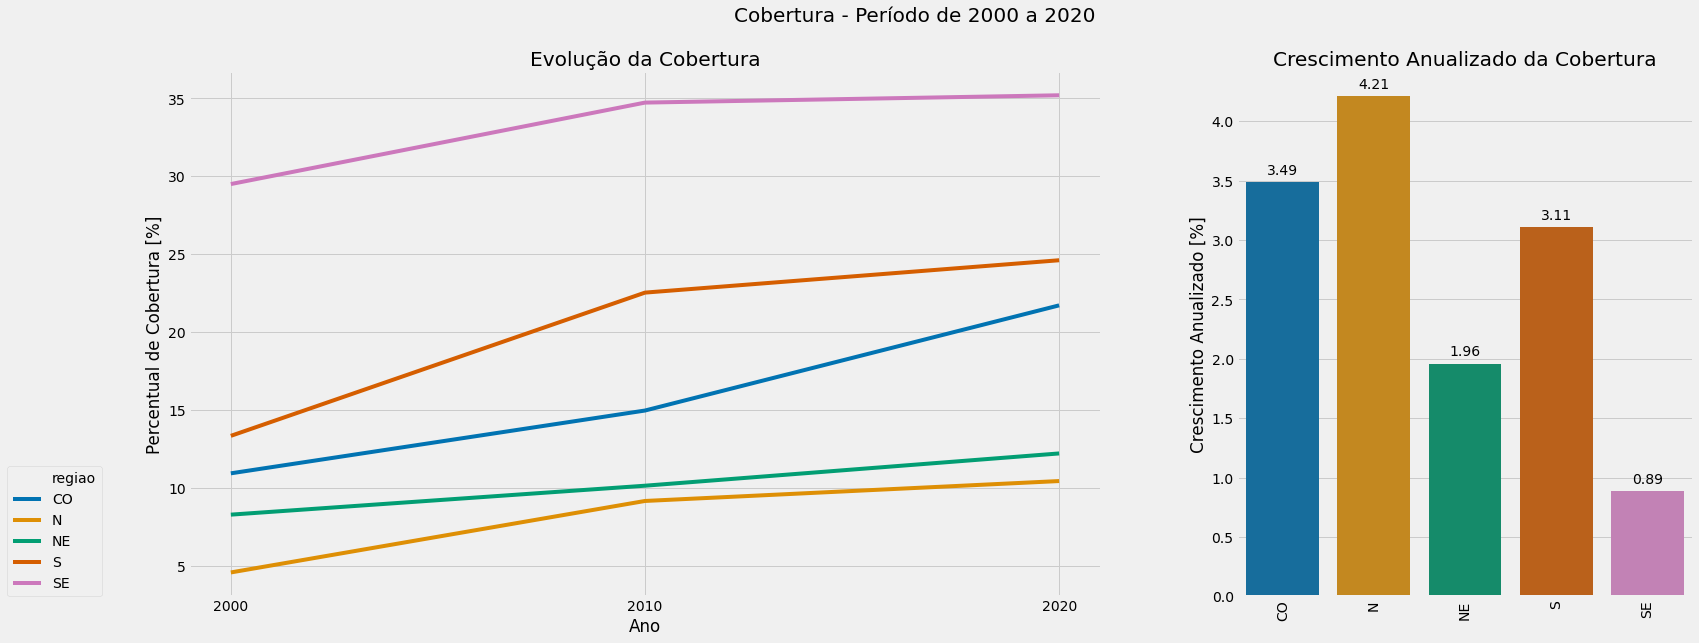

In [27]:
region_order = progressao_regiao['regiao'].unique()
palette = 'colorblind'

fig, axs = plt.subplots(1, 2, figsize=(24, 9), gridspec_kw={'width_ratios': [2, 1]})
fig.suptitle(f'Cobertura - Período de 2000 a 2020', fontsize=20)

g0 = sns.lineplot(
    data=progressao_regiao, 
    x='data_ref', 
    y='perc_cobertura', 
    hue='regiao', 
    ax=axs[0], 
    palette=palette, 
    hue_order=region_order
)
axs[0].set_xlabel('Ano')
axs[0].set_ylabel('Percentual de Cobertura [%]')
axs[0].set_title('Evolução da Cobertura')
g0.legend(bbox_to_anchor=(-0.2, 0), loc='lower left', borderaxespad=0.)

g1 = sns.barplot(
    data=cagr_regiao, 
    x='regiao', 
    y='perc_cobertura', 
    ax=axs[1], 
    palette=palette, 
    order=region_order
)
axs[1].set_title('Crescimento Anualizado da Cobertura')
axs[1].set_xlabel('')
axs[1].set_ylabel('Crescimento Anualizado [%]')
g1.set_xticklabels(g1.get_xticklabels(), rotation=90)    
add_value_labels(axs[1])

<a id='4'></a>
## 4. Participação das Operadoras: Share por Região (2012-2020)

### Visualização: Evolução da Participação de cada Empresa

Aqui observamos a variação da participação e o crescimento anualizado de cada prestadora de serviço, por região.

O interessante de analisar a evolução de participação é a relativa independencia em relação a ciclos economicos. 
Se assumirmos que não haverá crescimento nos próximos anos, algumas empresas ainda podem se beneficiar de uma tomada de share ou da manutenção de uma porção significativa de mercado.

#### Destaques Nacionais
1. __Perda de share das Unimeds__:
    - Mantém-se como maior incumbente em todas as regiões.
    - Aparecem com perda de share em todas as regiões, apesar de apresentar crescimento absoluto de seu número de beneficiários.
    - Perda é mais acentuada nas regiões Norte, Centroeste e Nordeste, nas quais a HAPVIDA tem mostrado crescimento significativo.
2. __Surgimento de segundo player dominante com proposta de atendimento verticalizado (HAPVIDA e GNDI)__: 
    - Nas regiões Nordeste, Norte e Centroeste, a HAPVIDA cresce significativamente, se tornando o 2° maior player em participação do mercado regional. 
    - Na região Sul, GNDI se aproxima de 10% do total de beneficiários da região.
    - HAPVIDA e GNDI são players que apresentam propostas de atendimento verticalizado.
    - Em um mercado que favorece a concentração e que tem se concentrado fortemente nas últimas décadas, empresas de rápido crescimento e que adquiram porção significativa do mercado passam a se beneficiar de fatores de escala relevantes como atração a clientes, negociação e credenciamento de prestadores de serviço para sua rede.

#### Destaques por Empresa
1. __HAPVIDA__
    - Crescimento acelerado em todas as regiões, com resultados mais expressivos de aumento de participação em CO, N, NE
    - Interessantemente, os momentos das 3 regiões parecem ser fases seguidas da expansão:
        - Centroeste: Crescimento e aumento de share acelerado, aparecimento como segundo maior player e atingimento de cerca de 15% de share
        - Norte: Consolidação como grande participante do mercado, predação ampla de clientes dos incumbentes (Unimeds)
        - Nordeste: Aproximação do percentual de participação no mercado tido pelas Unimeds. Desaceleração do crescimento de share e movimento de estabilização.
    - Esse "faseamento" indica que a empresa já conseguiu obter relevancia em dois mercados e pode adquirir boa parte do share do incumbente no Centroeste caso consiga repetir o processo em outra região
    - As regiões Norte e Nordeste são também as regiões em que há menor penetração de planos de saúde, o que suscita alguns pontos relevantes:
        - Possibilidade de expansão dos níveis de contratação da população dessas regiões em movimentos de catch-up de renda e de expansão dos gastos em saúde para níveis compatíveis com os vistos nas outras regiões do país.
            - População das regiões é ~4x a da região Centroeste.
            - Aumento em 5% da penetração de planos de saúde na região NE adicionaria ~2.2M novos contratos.
        - Mesmo com share considerável nessas regiões, número total de beneficiários não é ainda tão grande. Esse patamar pode mudar com a expansão na região Sudeste, na qual a empresa tem apenas 4.2% de participação.
2. __GNDI__
    - Momento na região Sul parece similar ao que vemos na região Centroeste para a HAPVIDA.
    - Uma vantagem de se consolidar como player de relevancia na região Sul é o atendimento de uma população de maior idade média e maior penetração de serviços de saúde.
    - Isso pode levar a um número elevado de beneficiários, ainda que geograficamente concentrado.
    - Região Sul é a que apresenta maior grau de concentração entre as OPS. Tendencia nacional indica que deve haver possibilidades de predação de share das Unimeds, como no restante do país.
    - Na região Sudeste, apresenta crescimento comparável com o observado para 
3. __Sulamerica__
    - Empresa apresenta participação relativamente constante nos seus principais mercados (SE).
    - Crescimento acelerado no número de beneficiários e na participação para serviços de administração de planos (ASO).
    - Crescimento sustentado do número de beneficiários nos planos próprios (1.76% a.a.)
    - Foco no business de saúde indica que empresa dedicará mais recursos e esforços na expansão das linhas de serviço acima, provavelmente em especial na região sudeste, onde apresenta maior predominancia.
4. __Unimeds__
    - Apresentam perda de market share em todos os mercados, com maior estabilidade na região Sul
    - Quantidade absoluta de beneficiários cresceu em todas as regiões, exceto Norte, a taxas >= 1% ao ano.
    
[↑](#topo)

In [28]:
empresas = pd.read_csv('../data/01_raw/operadora_empresa.csv')
empresas = empresas.rename(columns=str.lower)

In [29]:
benef_uf_path = '../data/01_raw/beneficiarios_uf'
benef_uf_files = [(os.path.join(benef_uf_path, f.name), f.name.replace('.csv', ''))  # (path, reference date)
                  for f in os.scandir(benef_uf_path) if not f.is_dir()]

benef_uf = pd.DataFrame()
for fp, ref_date in benef_uf_files:
    df = pd.read_csv(fp, encoding='utf-8-sig', sep=',')
    df['data_ref'] = ref_date
    benef_uf = pd.concat([benef_uf, df])

# Parsing do Código da Operadora
benef_uf = benef_uf.rename(columns=str.lower)
benef_uf['cod_operadora'] = benef_uf['operadora'].apply(lambda val: val.split('-')[0])
benef_uf['cod_operadora'] = benef_uf['cod_operadora'].astype(int)

# Marcação do UF a partir do nome do estado
estados = {
    'acre': 'AC',
    'alagoas': 'AL',
    'amapá': 'AP',
    'amazonas': 'AM',
    'bahia': 'BA',
    'ceará': 'CE',
    'distrito federal': 'DF',
    'espírito santo': 'ES',
    'goiás': 'GO',
    'maranhão': 'MA',
    'mato grosso': 'MT',
    'mato grosso do sul': 'MS',
    'minas gerais': 'MG',
    'pará': 'PA',
    'paraíba': 'PB',
    'paraná': 'PR',
    'pernambuco': 'PE',
    'piauí': 'PI',
    'rio de janeiro': 'RJ',
    'rio grande do norte': 'RN',
    'rio grande do sul': 'RS',
    'rondônia': 'RO',
    'roraima': 'RR',
    'santa catarina': 'SC',
    'são paulo': 'SP',
    'sergipe': 'SE',
    'tocantins': 'TO',
}
benef_uf = benef_uf.rename(columns=estados)

In [30]:
# Construção do histórico de participação por operadora, por UF
historico = empresas.merge(benef_uf, on='cod_operadora', how='inner')
historico = historico.drop('operadora', axis=1)
historico = historico.melt(id_vars=['cod_operadora', 'nome_empresa', 'data_ref'],
                           var_name='uf', value_name='beneficiarios')

# Consolidação das Operadoras nas Empresas relacionadas
historico_empresa = historico.groupby(['nome_empresa', 'data_ref', 'uf'])['beneficiarios'].sum()
historico_empresa = historico_empresa.reset_index()
historico_empresa = historico_empresa.sort_values(['nome_empresa', 'uf', 'data_ref'])

historico_empresa['regiao'] = historico_empresa['uf'].map(regioes)

In [31]:
### Evolução da Participação de cada Empresa por Região

# Participação por Região
total_regiao = historico_empresa.groupby(['regiao', 'data_ref']).sum()
operadora_regiao = historico_empresa.groupby(['nome_empresa', 'regiao', 'data_ref']).sum()
operadora_regiao = operadora_regiao.reset_index()

operadora_regiao = operadora_regiao.merge(total_regiao, how='inner', on=['regiao', 'data_ref'], suffixes=['', '_regiao'])
operadora_regiao['participacao_regiao'] = 100 * operadora_regiao['beneficiarios'] / operadora_regiao['beneficiarios_regiao']

# QTD de referencias utilizadas
n_years = historico_empresa['data_ref'].nunique()

# CAGR do Número de Beneficiários de cada Empresa por Região
cagr_empresa_regiao = cagr(historico_empresa, 'data_ref', ['regiao', 'nome_empresa'], 'beneficiarios', n_years)

# CAGR da participação
cagr_participacao_empresa = cagr(operadora_regiao, 'data_ref', ['regiao', 'nome_empresa'], 'participacao_regiao', n_years)

In [32]:
# Dados de Participação nos Extremos
part_final = operadora_regiao.query('data_ref == "202003"')[['nome_empresa', 'regiao', 'participacao_regiao']]
part_final = part_final.rename(columns={'participacao_regiao': 'participacao_2020'})

part_inicial = operadora_regiao.query('data_ref == "201203"')[['nome_empresa', 'regiao', 'participacao_regiao']]
part_inicial = part_inicial.rename(columns={'participacao_regiao': 'participacao_2012'})

# Dados de Crescimento no Período
crescimento = cagr_empresa_regiao.merge(cagr_participacao_empresa, on=['regiao', 'nome_empresa'], how='inner')
crescimento = crescimento.merge(part_inicial, on=['regiao', 'nome_empresa'], how='inner')
crescimento = crescimento.merge(part_final, on=['regiao', 'nome_empresa'], how='inner')
crescimento = crescimento.sort_values(['regiao', 'participacao_2020'], ascending=False)

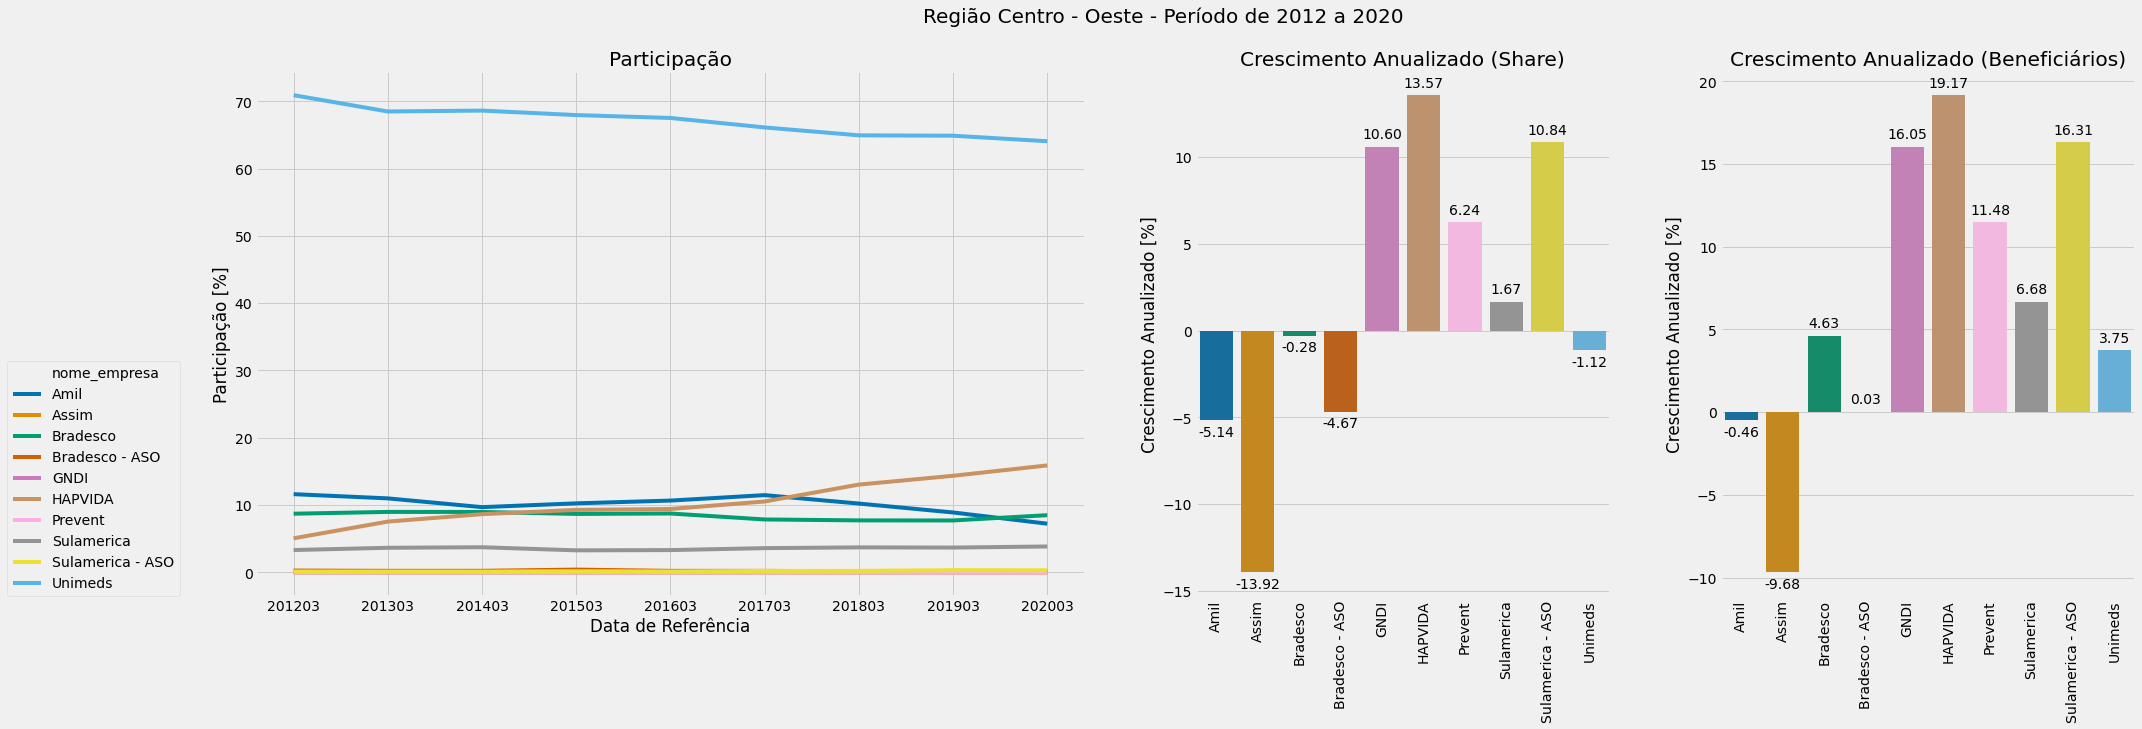

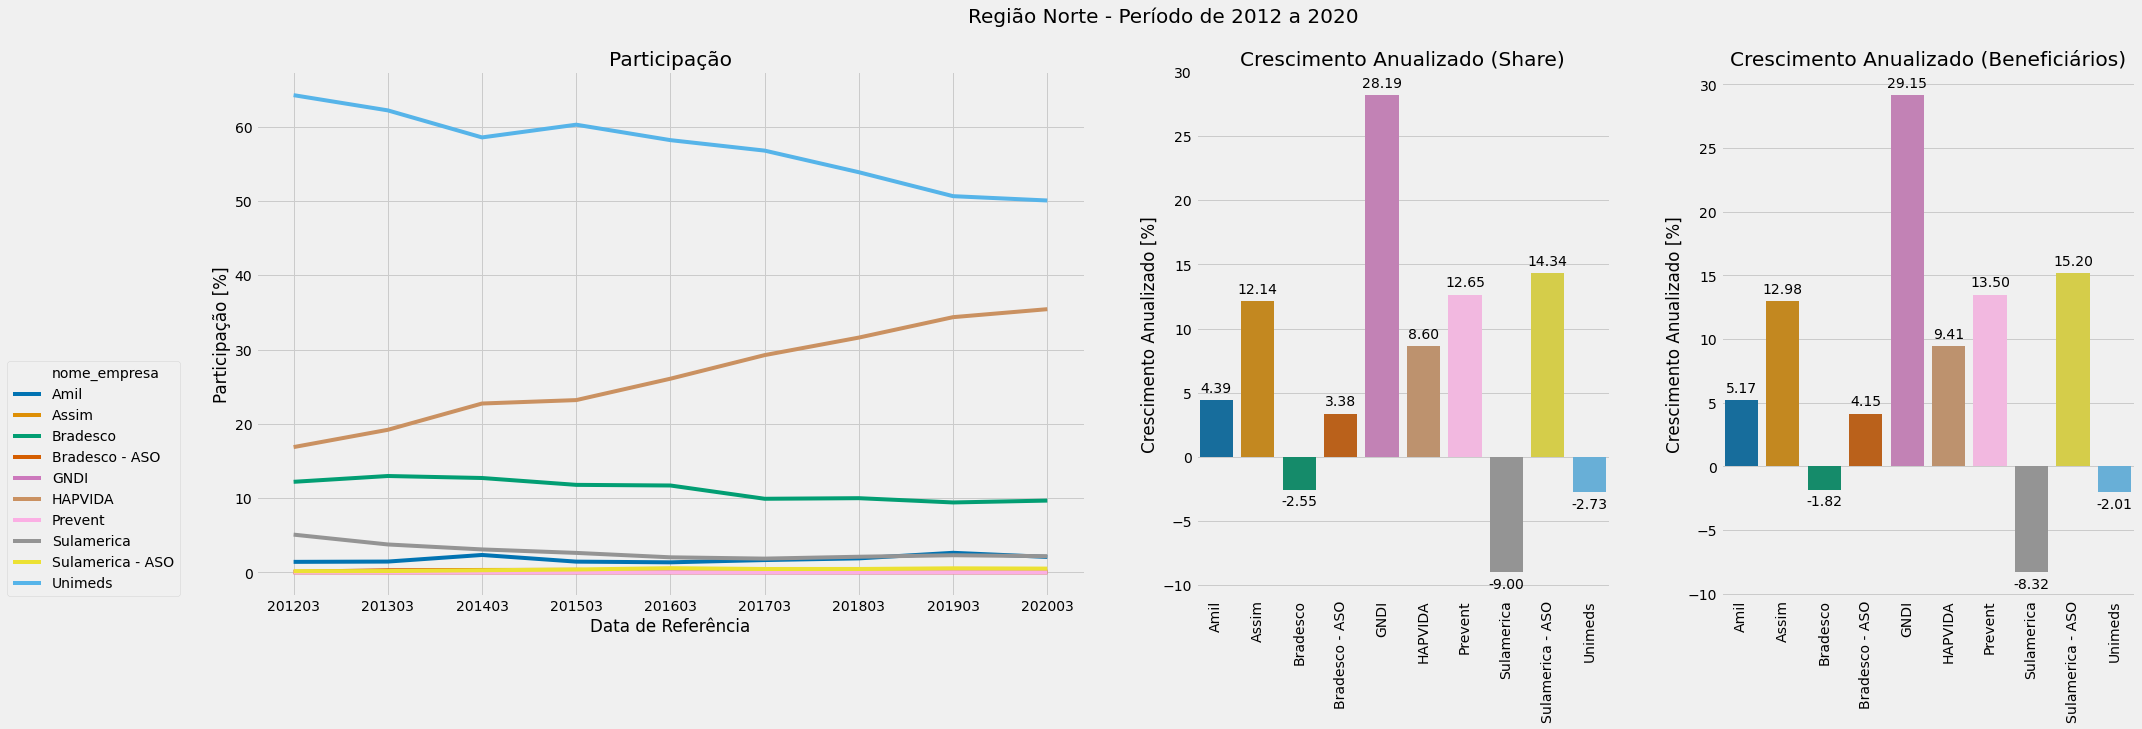

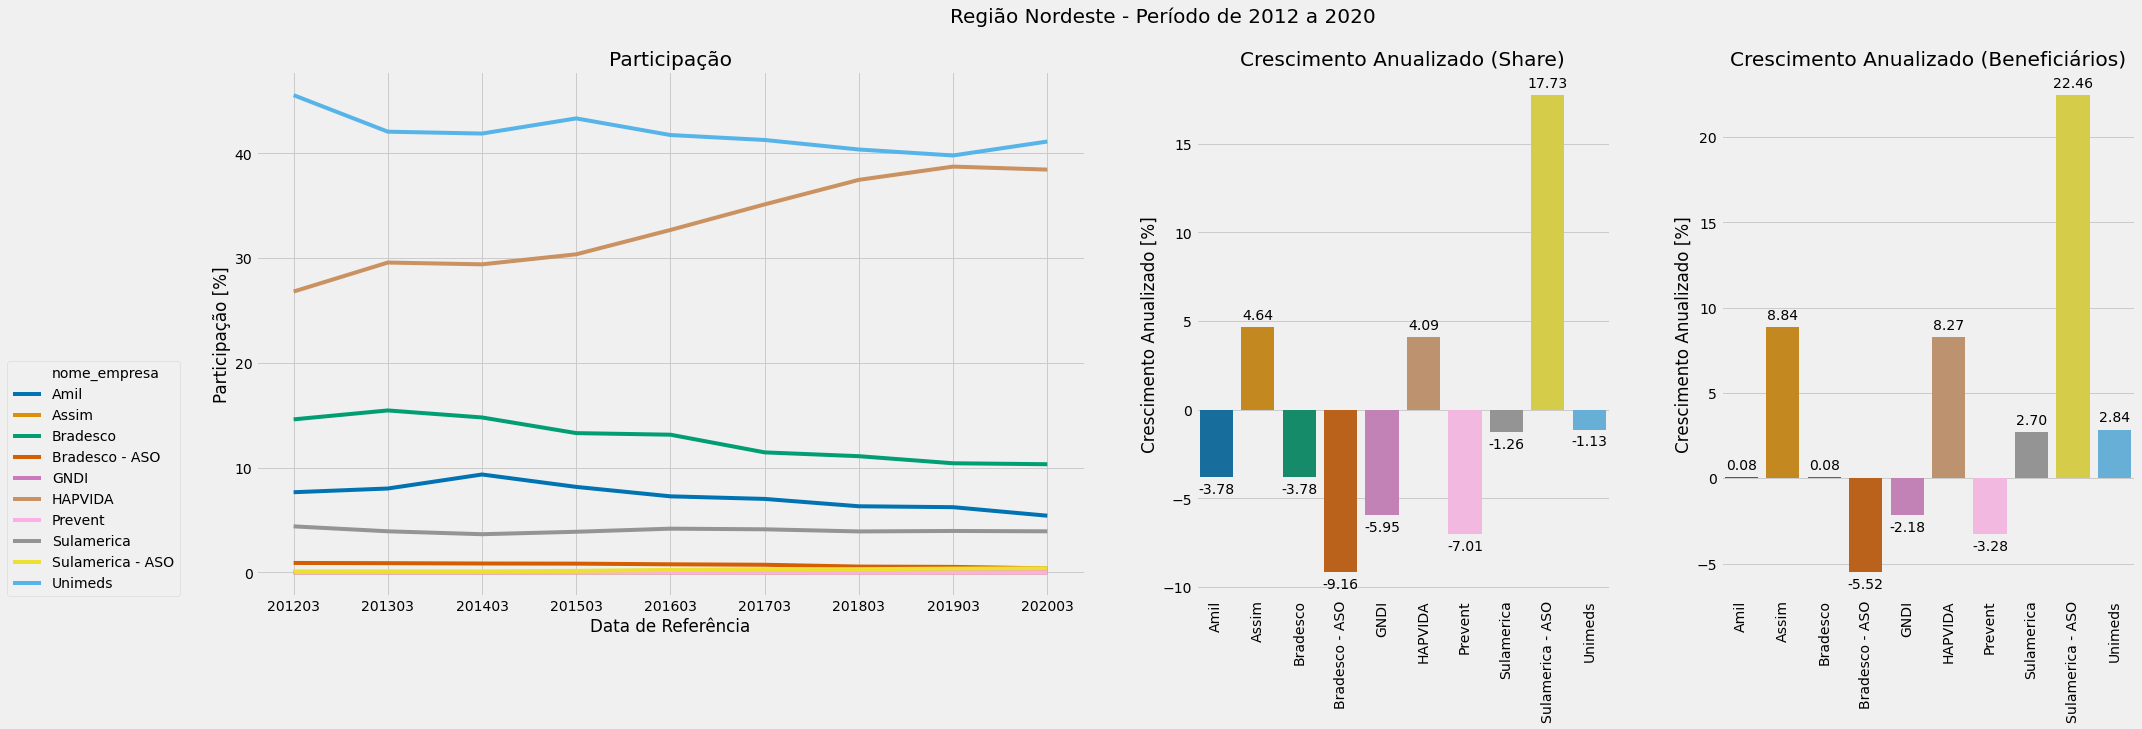

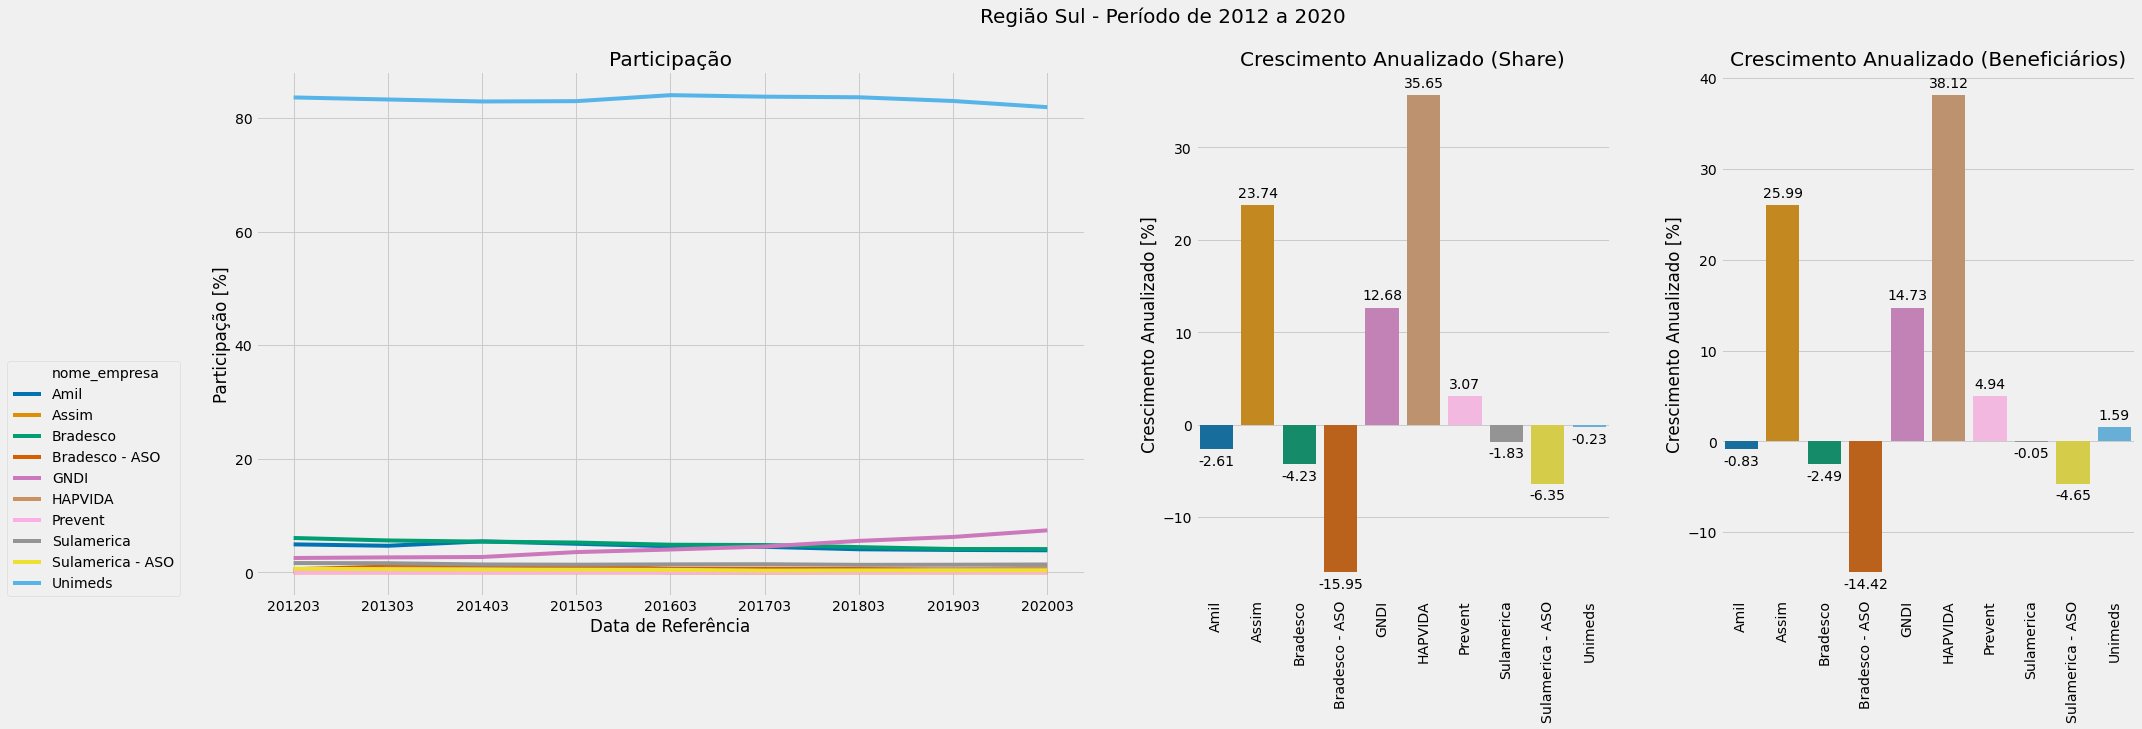

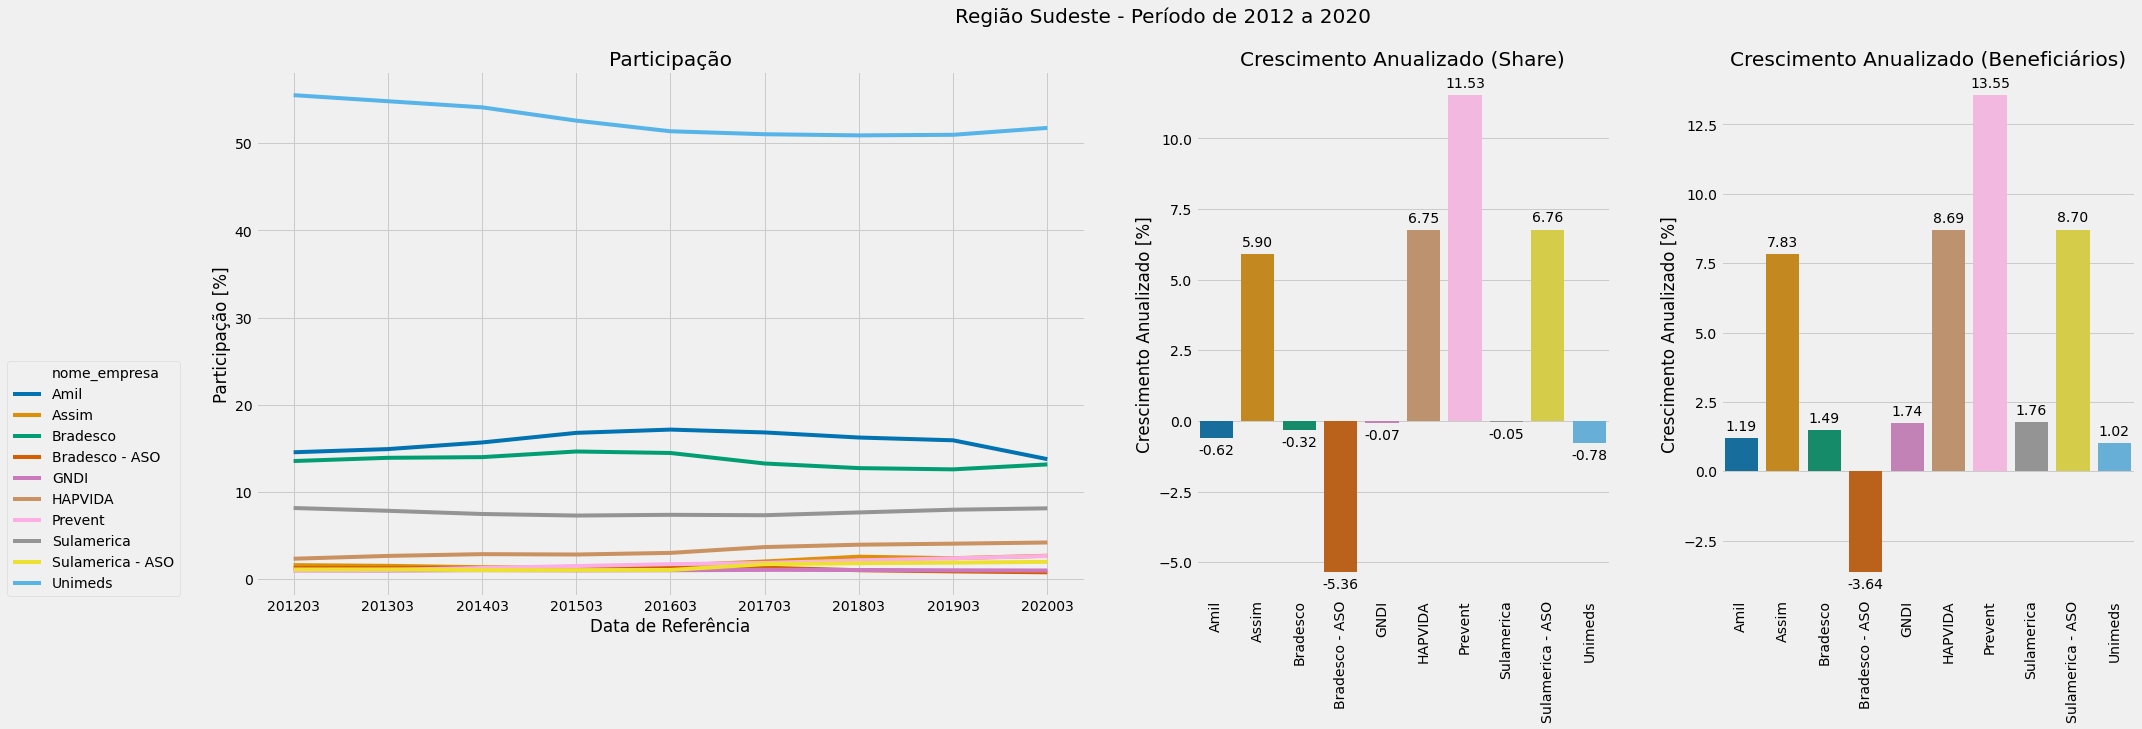

In [33]:
order = operadora_regiao['nome_empresa'].unique()
palette = 'colorblind'

for region in operadora_regiao['regiao'].unique():
    _part = operadora_regiao[operadora_regiao['regiao'] == region]
    _cagr = crescimento[crescimento['regiao'] == region]
    region_name = region_names[region]
    
    fig, axs = plt.subplots(1, 3, figsize=(30, 9), gridspec_kw={'width_ratios': [2, 1, 1]})
    fig.suptitle(f'Região {region_name} - Período de 2012 a 2020', fontsize=20)
    
    g0 = sns.lineplot(
        data=_part, 
        x='data_ref', 
        y='participacao_regiao', 
        hue='nome_empresa', 
        ax=axs[0], 
        palette=palette, 
        hue_order=order
    )
    axs[0].set_title('Participação')
    axs[0].set_xlabel('Data de Referência')
    axs[0].set_ylabel('Participação [%]')
    g0.legend(bbox_to_anchor=(-0.3, 0), loc='lower left', borderaxespad=0.)
    
    g1 = sns.barplot(
        data=_cagr, 
        x='nome_empresa', 
        y='participacao_regiao', 
        ax=axs[1], 
        palette=palette, 
        order=order
    )
    axs[1].set_title('Crescimento Anualizado (Share)')
    axs[1].set_xlabel('')
    axs[1].set_ylabel('Crescimento Anualizado [%]')
    g1.set_xticklabels(g1.get_xticklabels(), rotation=90)    
    add_value_labels(axs[1])
    
    g2 = sns.barplot(
        data=_cagr, 
        x='nome_empresa', 
        y='beneficiarios', 
        ax=axs[2], 
        palette=palette, 
        order=order
    )
    axs[2].set_title('Crescimento Anualizado (Beneficiários)')
    axs[2].set_xlabel('')
    axs[2].set_ylabel('Crescimento Anualizado [%]')
    plt.xticks(rotation=90)
    add_value_labels(axs[2])


<a id='5'></a>
## 5. Projeção do número de Beneficiários de Cada Empresa

Se assumirmos que o crescimento de cobertura seguirá o exposto no item [3](#3), podemos projetar o número de beneficiários de cada empresa, assumindo que a participação siga a mesma.
Tomamos aqui que o crescimento anualizado por região seguirá o mesmo dos últimos 20 anos.

Em um segundo momento, projetamos também como acreditamos que a participação de cada empresa evoluirá no futuro.
Essa projeção é feita tomando como base a taxa de crescimento anualizada da participação de cada empresa por região.

Essa estimativa assume independencia entre a variação de share das empresas e o aumento da penetração.
Essa suposição facilita o cálculo, mas pode não ser válida. 
Dois pontos relevantes a avaliar para entender melhor esse comportamento são:
- Distribuição de share de cada empresa dentro dos novos beneficiários
- Quantidade de portabilidades ou transferencias de planos

Um outro ponto relevante é que as taxas de crescimento anualizadas foram "carregadas" dos anos passados, mas essas também sofrem alterações de outros fatores.
- Taxa de Crescimento da Cobertura
    - A taxa de crescimento da cobertura de assistencia médico-hospitalar é, como vimos, bastante afetada pela variação do PIB e da taxa de emprego formal
    - Uma estimativa dessas duas grandezas pode basear uma estimativa mais precisa do crescimento da penetração, assim como uma estimativa do efeito de "catching up" do PIB.
- Taxa de Variação do Market Share
    - A taxa de variação de participação das empresas deve mudar conforme o próprio nível de participação da empresa no mercado, caindo para empresas maiores
    - Poderíamos observar se as empresas tem tidos volume de vendas crescente, que acompanhe o crescimento de share, ou constante, indicando essa amortizaçãó
    - Os players incumbentes podem - e certamente vão - tomar atitudes para desacelerar o ganho de share de seus concorrentes
    
[↑](#topo)

In [34]:
projecao_regiao = regiao.merge(cagr_regiao, on=['regiao'], how='inner')
projecao_regiao['tx_crescimento_cobertura'] = 1 + 0.01 * projecao_regiao['perc_cobertura']
projecao_regiao = projecao_regiao.drop(['perc_cobertura'], axis=1)
projecao_regiao['perc_cobertura_projetado_2030'] = projecao_regiao['perc_cobert_assistencia_medica'] * (projecao_regiao['tx_crescimento_cobertura'] ** 10)  # considerando um periodo de dez anos
projecao_regiao['benef_assistencia_medica_2030'] = 0.01 * projecao_regiao['perc_cobertura_projetado_2030'] * projecao_regiao['populacao']
projecao_regiao['benef_assistencia_medica_2030'] = projecao_regiao['benef_assistencia_medica_2030'].astype(int)

projecao_regiao = projecao_regiao[['regiao', 'perc_cobertura_projetado_2030', 'benef_assistencia_medica_2030']]

In [35]:
projecao_share = operadora_regiao.merge(cagr_empresa_regiao, on=['regiao', 'nome_empresa'], how='inner', suffixes=('', '_cagr'))
projecao_share = projecao_share[projecao_share['data_ref'] == '202003']
projecao_share = projecao_share.drop(['data_ref', 'beneficiarios_regiao'], axis=1)
projecao_share = projecao_share.rename(columns={'beneficiarios_cagr': 'cagr_participacao'})
projecao_share['tx_crescimento_share'] = 1 + 0.01 * projecao_share['cagr_participacao']

projecao_share['share_projetado_2030'] = projecao_share['participacao_regiao'] * (projecao_share['tx_crescimento_share'] ** 10)  # considerando um periodo de dez anos

fator_norm_regiao = projecao_share.groupby('regiao')['share_projetado_2030'].sum()
fator_norm_regiao = fator_norm_regiao.reset_index()
fator_norm_regiao = fator_norm_regiao.rename(columns={'share_projetado_2030': 'fator_norm'})

projecao_share = projecao_share.merge(fator_norm_regiao, on='regiao', how='inner')
projecao_share['share_projetado_2030'] = 100 * projecao_share['share_projetado_2030'] /  projecao_share['fator_norm']

projecao_share = projecao_share[['nome_empresa', 'regiao', 'beneficiarios', 'share_projetado_2030']]

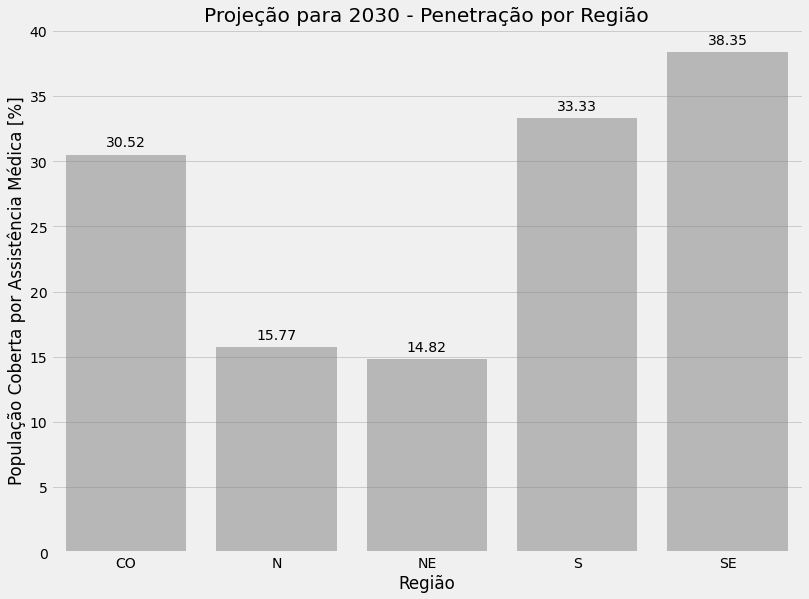

In [36]:
_, ax = plt.subplots(1, figsize=(12, 9))
sns.barplot(data=projecao_regiao, x='regiao', y='perc_cobertura_projetado_2030', 
            ax=ax, color='grey', alpha=0.5)
plt.xlabel('Região')
plt.ylabel('População Coberta por Assistência Médica [%]')
plt.title('Projeção para 2030 - Penetração por Região')
add_value_labels(ax)

In [37]:
projetado = projecao_share.merge(projecao_regiao, on=['regiao'], how='inner')
projetado['beneficiarios_operadora_2030'] = (projetado['benef_assistencia_medica_2030'] * projetado['share_projetado_2030'] * 0.01).astype(int)

cresc_projetado_empresa = projetado.groupby(['nome_empresa'])[['beneficiarios', 'beneficiarios_operadora_2030']].sum()
cresc_projetado_empresa['crescimento_10anos'] = 100 * cresc_projetado_empresa['beneficiarios_operadora_2030'] / cresc_projetado_empresa['beneficiarios']
cresc_projetado_empresa = cresc_projetado_empresa.reset_index()
cresc_projetado_empresa['novos_beneficiarios'] = (cresc_projetado_empresa['beneficiarios_operadora_2030'] - cresc_projetado_empresa['beneficiarios']) / 10 ** 3

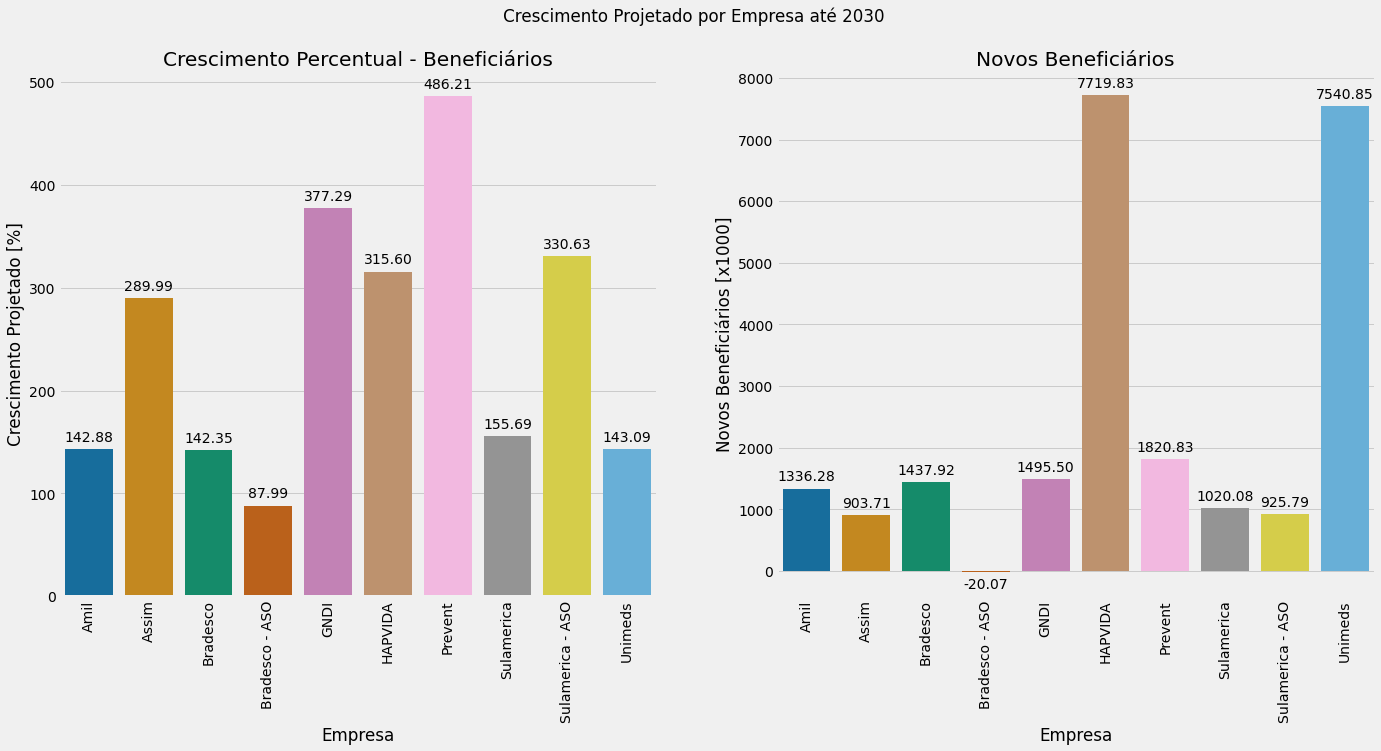

In [38]:
fig, ax = plt.subplots(1, 2, figsize = (21, 9))

fig.suptitle('Crescimento Projetado por Empresa até 2030')


g0 = sns.barplot(data=cresc_projetado_empresa, x='nome_empresa', y='crescimento_10anos', palette=palette, order=order, ax=ax[0])
ax[0].set_xlabel('Empresa')
ax[0].set_ylabel('Crescimento Projetado [%]')
ax[0].set_title('Crescimento Percentual - Beneficiários')

g0.set_xticklabels(g0.get_xticklabels(), rotation=90)
add_value_labels(ax[0])


g1 = sns.barplot(data=cresc_projetado_empresa, x='nome_empresa', y='novos_beneficiarios', palette=palette, order=order, ax=ax[1])
ax[1].set_xlabel('Empresa')
ax[1].set_ylabel('Novos Beneficiários [x1000]')
ax[1].set_title('Novos Beneficiários')

g1.set_xticklabels(g1.get_xticklabels(), rotation=90)
add_value_labels(ax[1])
